Clustering

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer

In [2]:
pd.set_option('display.max_columns', None)

In [6]:
transaction = pd.read_csv("data/transaction_processed.csv")
user = pd.read_csv("data/user_processed.csv")

In [11]:
transaction.head(1)

,id,client_id,amount,merchant_id,merchant_category,month,hour,use_chip_Chip Transaction,use_chip_Online Transaction,use_chip_Swipe Transaction
0,22326462,496,119.35,30286,Telecommunication Services,1,0,1,0,0


In [10]:
user.head(1)

,id,current_age,retirement_age,birth_year,birth_month,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,gender_Female,gender_Male
0,825,53,66,1966,11,462 Rose Lane,34.15,-117.76,29278.0,59696.0,127613.0,787,5,1,0


In [12]:
transaction.rename(columns = {'id':'transaction_id'}, inplace=True)

In [14]:
user_transaction = pd.merge(user, transaction, left_on='id', right_on='client_id', how='inner')

In [15]:
user_transaction.head(1)

,id,current_age,retirement_age,birth_year,birth_month,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,gender_Female,gender_Male,transaction_id,client_id,amount,merchant_id,merchant_category,month,hour,use_chip_Chip Transaction,use_chip_Online Transaction,use_chip_Swipe Transaction
0,825,53,66,1966,11,462 Rose Lane,34.15,-117.76,29278.0,59696.0,127613.0,787,5,1,0,22326900,825,178.32,60569,Wholesale Clubs,1,6,0,0,1


In [16]:
user_transaction.duplicated().sum()

0

In [19]:
#user_transaction['address'].unique().shape

In [17]:
user_transaction['num_credit_cards'][user_transaction['num_credit_cards'] == 0].shape

(0,)

In [22]:
columns_to_select = ['current_age','retirement_age','per_capita_income','yearly_income', 'total_debt', 'credit_score', 'num_credit_cards', 'amount', 'month', 'hour', 'use_chip_Chip Transaction', 'use_chip_Online Transaction', 'use_chip_Swipe Transaction', 'gender_Female', 'gender_Male']

In [23]:
clustering_v1 = user_transaction[columns_to_select]

In [24]:
clustering_v1.duplicated().sum()

37358

In [25]:
clustering_v1.head(2)

,current_age,retirement_age,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,amount,month,hour,use_chip_Chip Transaction,use_chip_Online Transaction,use_chip_Swipe Transaction,gender_Female,gender_Male
0,53,66,29278.0,59696.0,127613.0,787,5,178.32,1,6,0,0,1,1,0
1,53,66,29278.0,59696.0,127613.0,787,5,105.69,1,6,0,0,1,1,0


In [26]:
clustering_v2 = clustering_v1.copy()

In [27]:
col_names = ['current_age', 'retirement_age', 'per_capita_income', 'yearly_income',
       'total_debt', 'credit_score', 'num_credit_cards', 'amount', 'month',
       'hour']

sd = StandardScaler()
clustering_v2[col_names] = sd.fit_transform(clustering_v2[col_names])

In [31]:
#scaled data 
clustering_v2.head(2)

,current_age,retirement_age,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,amount,month,hour,use_chip_Chip Transaction,use_chip_Online Transaction,use_chip_Swipe Transaction,gender_Female,gender_Male
0,-0.042444,-0.142246,0.436152,0.526025,1.311374,1.104886,0.738175,1.751286,-1.578849,-1.245251,0,0,1,1,0
1,-0.042444,-0.142246,0.436152,0.526025,1.311374,1.104886,0.738175,0.759151,-1.578849,-1.245251,0,0,1,1,0


In [30]:
def get_n_clusters(data):
    model = KMeans(init='k-means++', random_state=42)
    visualizer = KElbowVisualizer(model, k=(1,10),size=(1080, 500))
    visualizer.fit(data)
    visualizer.show()
    return visualizer.elbow_value_

In [34]:
def train_model(data):
    num_clusters = get_n_clusters(data)

    kmeans = KMeans(n_clusters = num_clusters, init='k-means++',random_state=42)
    kmeans.fit(data)   

    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)

    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans.labels_, cmap='Pastel2')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('Cluster Visualization')
    plt.show()

    return kmeans, data

In [35]:
def get_clusters(model, data, cluster_df):
    clusters = model.fit_predict(data)
    cluster_df['cluster'] = clusters
    return cluster_df

Iteration 1 - unscaled data

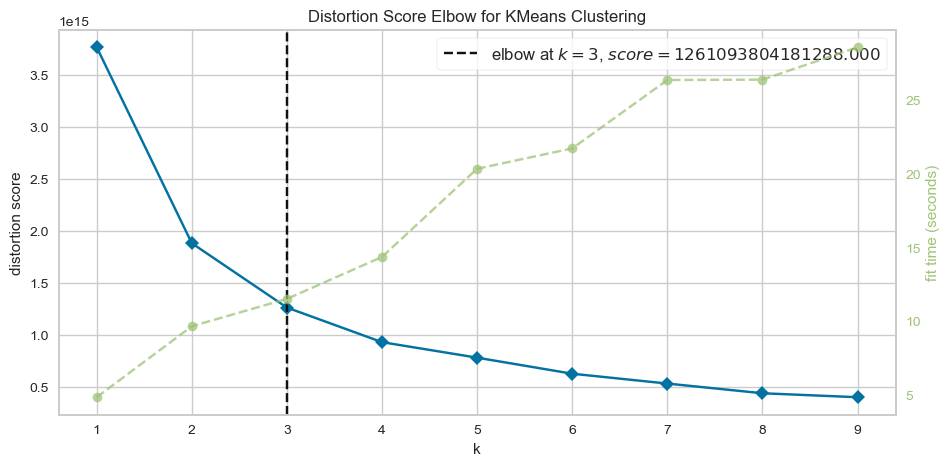

In [ ]:
n_clusters_v1 = get_n_clusters(clustering_v1)

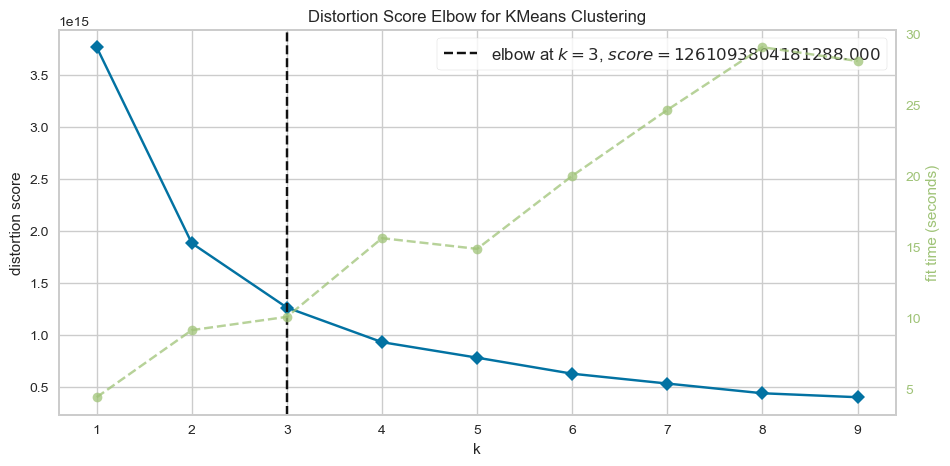

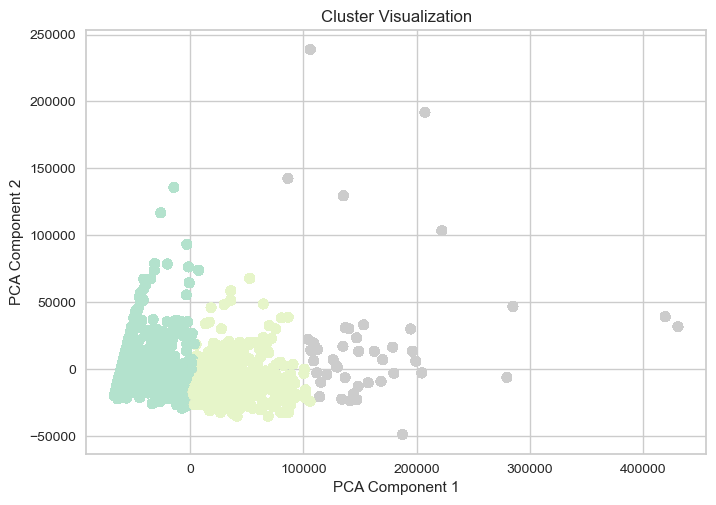

In [36]:
model_v1, clustering_v1 = train_model(clustering_v1)

In [37]:
user_transaction_clusters_v1 = user_transaction.copy()

In [38]:
user_transaction_clusters_v1 = get_clusters(model_v1, clustering_v1, user_transaction_clusters_v1)

Iteration 2 - scaled data

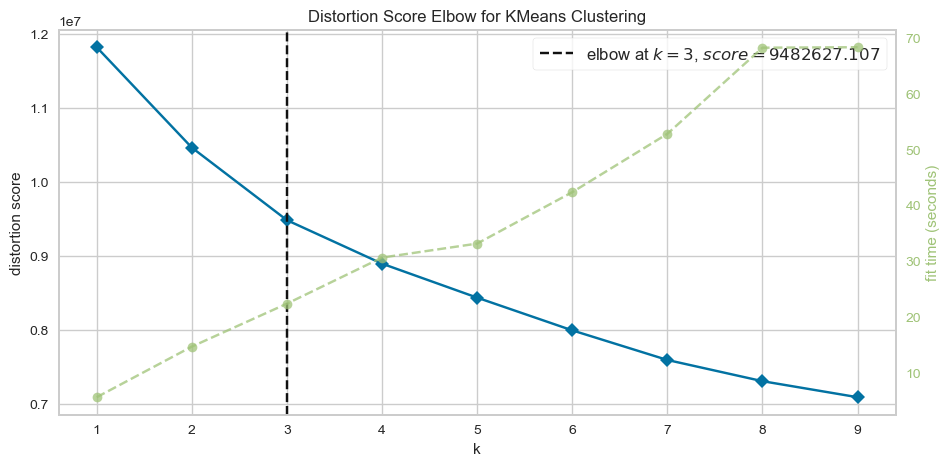

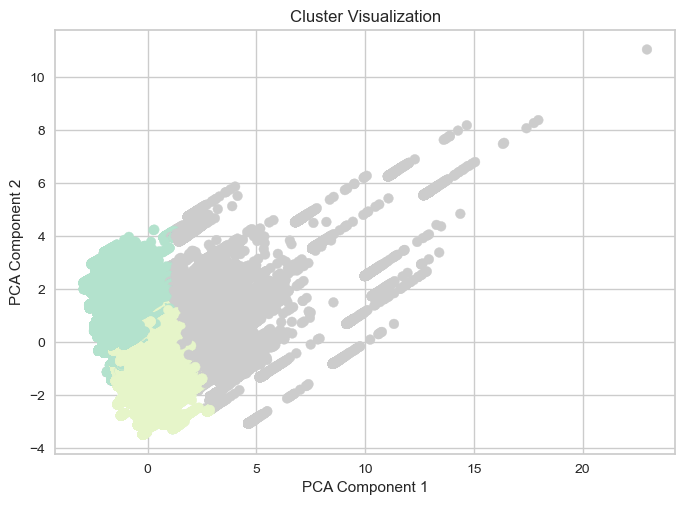

In [39]:
model_v2, clustering_v2 = train_model(clustering_v2)

In [40]:
user_transaction_clusters_v2 = user_transaction.copy()

In [41]:
user_transaction_clusters_v2 = get_clusters(model_v2, clustering_v2, user_transaction_clusters_v2)

Iteration 3 - scaled data, outliers removed

In [62]:
def remove_outliers(df, columns, threshold = 1.5):
    for col in columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - threshold * iqr
        upper_bound = q3 + threshold * iqr
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

In [63]:
columns_to_check = ['current_age',	'retirement_age',	'per_capita_income',	'yearly_income',	'total_debt',	'credit_score',	'num_credit_cards',	'amount','month','hour']  # Specify the columns
clustering_v1_outlier_removed = remove_outliers(clustering_v1, columns_to_check)

In [64]:
clustering_v1.shape

(1078249, 15)

In [65]:
clustering_v1_outlier_removed.shape

(1078249, 15)

In [66]:
user_transaction_clusters_v1.to_csv("data/user_transaction_clusters_v1.csv",index=False)